In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import pipeline
import json
from skimage import util
from skimage import io


def read_annotation_file(path):
    '''This creates a dictionary where the first key is the sequence id,
    and the second key is the frame id, which contains a list of the 
    annotation points as lists of floating numbers.
    For example sequence #1 shown above contains 3 objects, which are visible in both frames #1 and #3.'''
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict


def get_targets(dataset, seqid):
    '''Returns array of n_objects x n_frames x coords'''
    return np.array([dataset[seqid][frame] for frame in dataset[seqid]]).swapaxes(0, 1)


def draw_circle(ax, r, c, radius, color):
    circle = plt.Circle((c, r), radius, color=color, fill=False)
    ax.add_artist(circle)

    
def draw_target(ax, r, c):
    draw_circle(ax, r, c, radius=10, color='r')
    
    
def draw_prediction(ax, r, c):
    draw_circle(ax, r, c, radius=15, color='g')

    
def get_sequence(seqid):
    frames = [util.img_as_float(io.imread(f"../spotGEO/train/{seqid}/{i+1}.png", as_gray=True)) for i in range(0, 5)]
    frames = np.array(frames)
    return frames


def extract_region(arr, r0, c0, radius):
    """ Returns the values within a radius of the given x, y coordinates """
    return arr[(r0 - radius) : (r0 + radius + 1), (c0 - radius) : (c0 + radius + 1)]


In [2]:
# seqid = 59
seqid = 1

dataset = read_annotation_file('../spotGEO/train_anno.json')

targets = get_targets(dataset, seqid)

frames = get_sequence(seqid)


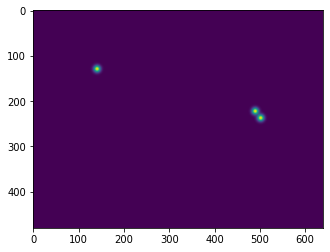

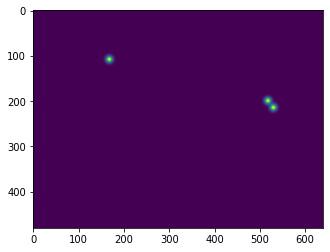

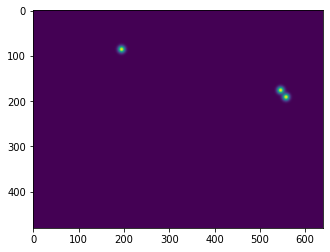

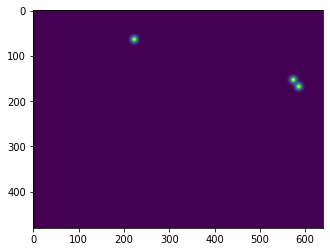

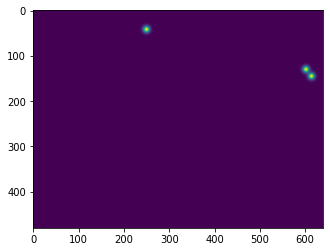

In [3]:
from skimage import morphology
from skimage import filters
from skimage import exposure

def process(Iin, targets):
    Iout = np.zeros(Iin.shape)
    for c, r in targets:
        Iout[int(r + 0.5), int(c + 0.5)] = 1
    Iout = filters.gaussian(Iout, sigma=5)
    Iout = exposure.rescale_intensity(Iout)
    return Iout


for frameid in range(0, 5):
    Iin = frames[frameid]
    Iout = process(Iin, targets[:, frameid])
    
    plt.imshow(Iout, vmin=0, vmax=1)
    plt.show()

In [8]:
from skimage import metrics
from skimage import util

def asymmetric_mse(Itrue, Ipred, alpha):
    Idiff = Itrue - Ipred

    w = 1e6*np.absolute(alpha - np.ones(Idiff.shape)*(Idiff < 0))
    mse = np.mean(w*np.square(Idiff))
    
    return mse

In [10]:
# Compute mse for always true, always false and random

frameid = 0

Itrue = process(frames[frameid], targets[:, frameid])

zeros_mse = asymmetric_mse(Itrue, np.zeros(Itrue.shape), alpha=0.9)
ones_mse = asymmetric_mse(Itrue, np.ones(Itrue.shape), alpha=0.9)
random_mse = asymmetric_mse(Itrue, util.random_noise(np.zeros(Itrue.shape), mode='s&p', salt_vs_pepper=1e-3), alpha=0.9)

print('Zero', zeros_mse)
print('Ones', ones_mse)
print('Random', random_mse)

Zero 700.9058435742809
Ones 99771.29806676655
Random 708.0673019076143


In [ ]:
def compute_mse(scale):
    frameid = 0

    Itrue = process(frames[frameid], targets[:, frameid])

    n = 1e-4

    coords = targets[:, frameid] + np.random.normal(scale=scale, size=(len(targets[:, frameid]), 2))
    Ipred = process(frames[frameid], coords)

    mse = asymmetric_mse(Itrue, Ipred, alpha=0.9)
    
    return mse

t = np.linspace(0.01, 10, num=20)
mse = np.stack([[compute_mse(scale) for scale in t] for i in range(100)])

m_mse = np.mean(mse, axis=0)

plt.plot(t, m_mse)
plt.show()